<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Problem-description" data-toc-modified-id="Problem-description-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Problem description</a></span></li><li><span><a href="#Imtort-data" data-toc-modified-id="Imtort-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Imtort data</a></span></li><li><span><a href="#EDA" data-toc-modified-id="EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>EDA</a></span></li><li><span><a href="#Split-and-vectorize-data" data-toc-modified-id="Split-and-vectorize-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Split and vectorize data</a></span></li><li><span><a href="#Train-models" data-toc-modified-id="Train-models-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Train models</a></span></li><li><span><a href="#Select-best-model" data-toc-modified-id="Select-best-model-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Select best model</a></span></li><li><span><a href="#Train-best-model-on-full-train" data-toc-modified-id="Train-best-model-on-full-train-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Train best model on full train</a></span></li><li><span><a href="#Save-model" data-toc-modified-id="Save-model-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Save model</a></span></li></ul></div>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import pandas as pd
import seaborn as sns
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score,recall_score, f1_score
from sklearn.utils import shuffle

%mathplotlib inline

UsageError: Line magic function `%mathplotlib` not found.


## Problem description

We will try to create a drug selection model. This will simplify the process of prescribing the drug based on test results.

## Imtort data

In [3]:
# We will use dataset from here: https://www.kaggle.com/datasets/prathamtripathi/drug-classification/code

data = pd.read_csv('drug200.csv')

In [3]:
data.head()

,Age,Sex,BP,Cholesterol,Na_to_K,Drug
0,23,F,HIGH,HIGH,25.355,DrugY
1,47,M,LOW,HIGH,13.093,drugC
2,47,M,LOW,HIGH,10.114,drugC
3,28,F,NORMAL,HIGH,7.798,drugX
4,61,F,LOW,HIGH,18.043,DrugY


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          200 non-null    int64  
 1   Sex          200 non-null    object 
 2   BP           200 non-null    object 
 3   Cholesterol  200 non-null    object 
 4   Na_to_K      200 non-null    float64
 5   Drug         200 non-null    object 
dtypes: float64(1), int64(1), object(4)
memory usage: 9.5+ KB


In [5]:
data.describe()

,Age,Na_to_K
count,200.000000,200.000000
mean,44.315000,16.084485
std,16.544315,7.223956
min,15.000000,6.269000
25%,31.000000,10.445500
50%,45.000000,13.936500
75%,58.000000,19.380000
max,74.000000,38.247000


## EDA

In [6]:
num_cols = list(data.dtypes[data.dtypes != 'object'].index)
cat_cols = list(data.dtypes[data.dtypes == 'object'].index)

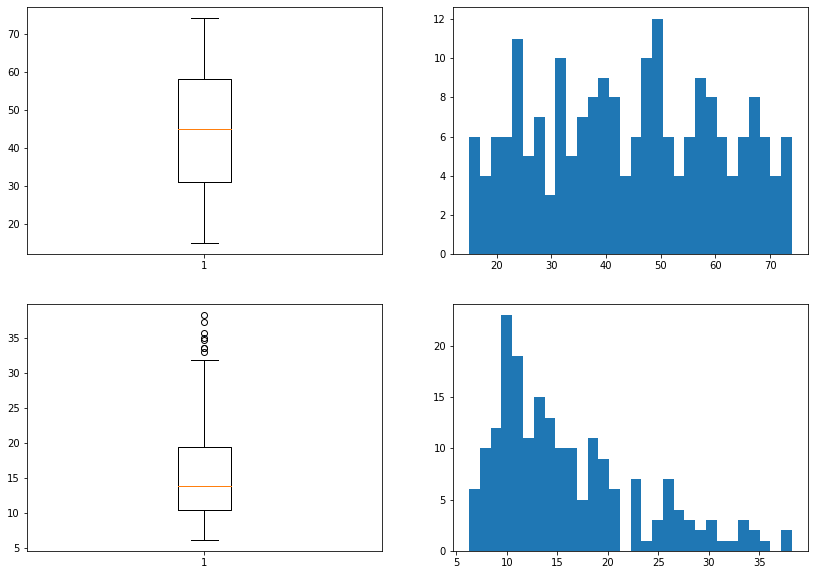

In [7]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
for i, col in enumerate(num_cols):
    axs[i, 0].boxplot(data[col]);
    axs[i, 1].hist(data[col], bins=30);

In [8]:
for col in cat_cols:
    print(col)
    print(data[col].value_counts())
    print()

Sex
M    104
F     96
Name: Sex, dtype: int64

BP
HIGH      77
LOW       64
NORMAL    59
Name: BP, dtype: int64

Cholesterol
HIGH      103
NORMAL     97
Name: Cholesterol, dtype: int64

Drug
DrugY    91
drugX    54
drugA    23
drugC    16
drugB    16
Name: Drug, dtype: int64



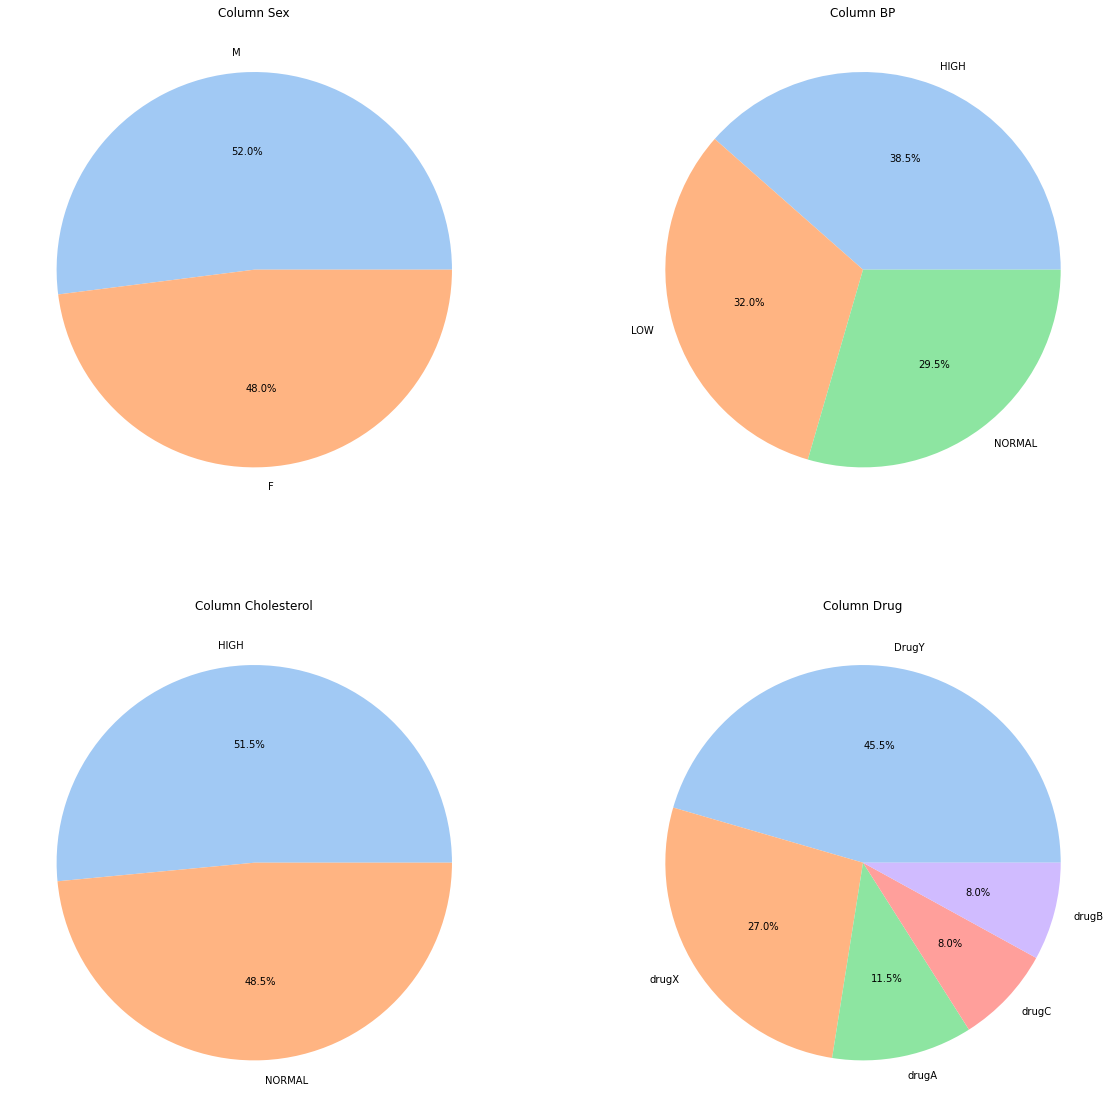

In [9]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
for ax, col in zip(axs.flat, cat_cols):
    ax.set_title(f'Column {col}')
    colors = sns.color_palette('pastel')
    ax.pie(data[col].value_counts(), labels=data[col].value_counts().index, colors=colors, autopct='%1.1f%%')

We have a class disbalance in the target attribute - Drug.

In [4]:
# replace target to num
for i, k in enumerate(list(data['Drug'].value_counts().index)):
    data.loc[data['Drug'] == k, ['Drug']] = i
data['Drug']

0      0
1      3
2      3
3      1
4      0
      ..
195    3
196    3
197    1
198    1
199    1
Name: Drug, Length: 200, dtype: object

In [11]:
data['Drug'].value_counts()

0    91
1    54
2    23
3    16
4    16
Name: Drug, dtype: int64

In [5]:
# use oversimpling for kill disbalance

def upsample(data):
    repeater = 100 // (data['Drug'].value_counts() / data['Drug'].sum() * 100) # repeater for evry class
    data_unsampled = pd.DataFrame(columns=data.columns)
    for i, r in enumerate(repeater):
        data_unsampled = shuffle(pd.concat([data_unsampled] + [data[data['Drug'] == i]] * int(r)), random_state=42)
    
    return data_unsampled.reset_index(drop=True)

upsampled_data = upsample(data)

# check balance
print('New class balance:')
print(upsampled_data['Drug'].value_counts())

New class balance:
Drug
4    208
3    208
2    207
0    182
1    162
Name: count, dtype: int64


It's better.

## Split and vectorize data

In [6]:
# split

df_features = upsampled_data.drop(['Drug'], axis=1)
df_target = upsampled_data['Drug']

In [7]:
feature_full_train, feature_test, target_full_train, target_test = train_test_split(df_features, df_target, random_state=1, test_size=0.2, stratify=df_target)
feature_train, feature_val, target_train, target_val = train_test_split(feature_full_train, target_full_train, random_state=1, test_size=0.25, stratify=target_full_train)

#Check 60/20/20 
list = [feature_train, feature_val, feature_test]

for feat in list:
    share = round(len(feat) / len(df_features), 2)
    print(f'The share of values from the total sample is {share}')

The share of values from the total sample is 0.6
The share of values from the total sample is 0.2
The share of values from the total sample is 0.2


In [8]:
target_val = target_val.astype(int).values
target_test = target_test.astype(int).values
target_train = target_train.astype(int).values
target_full_train = target_full_train.astype(int).values

In [136]:
# vectorize fitures

def vectorize(df_train, df_val):
    dv = DictVectorizer(sparse=False)

    train_dict = df_train.to_dict(orient='records')
    X_train = dv.fit_transform(train_dict)


    val_dict = df_val.to_dict(orient='records')
    X_val = dv.transform(val_dict)

    return X_train, X_val, dv

In [137]:
X_train, X_val, dv = vectorize(feature_train, feature_val)

## Train models

We will train RandomForest and XGBoost

Let's train an RF model

In [140]:
model_rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
model_rf.fit(X_train, target_train)
y_pred_rf = model_rf.predict(X_val).astype(int)

accuracy_score(target_val, y_pred_rf)


0.9896907216494846

In [241]:
scores = []

for depth in range(1, 10, 1):
    for n_est in range(1, 20, 1):
        model_rf = RandomForestRegressor(random_state=1, max_depth=depth, n_estimators=n_est, n_jobs=-1)
        model_rf.fit(X_train, target_train)
        y_pred = model_rf.predict(X_val).astype(int)
        accar = accuracy_score(target_val, y_pred)
        scores.append((depth, n_est, accar))

In [242]:
sc_df = pd.DataFrame(data=scores, columns=['max_depth', 'n_estimators', 'accuracy'])
sc_df

,max_depth,n_estimators,accuracy
0,1,1,0.402062
1,1,2,0.402062
2,1,3,0.402062
3,1,4,0.402062
4,1,5,0.402062
...,...,...,...
166,9,15,0.989691
167,9,16,0.989691
168,9,17,0.989691
169,9,18,0.989691


In [250]:
sc_df.accuracy = sc_df.accuracy.round(4)
sc_df[sc_df.accuracy == max(sc_df.accuracy)].sort_values(['max_depth', 'n_estimators'])

,max_depth,n_estimators,accuracy
76,5,1,0.9897
77,5,2,0.9897
78,5,3,0.9897
79,5,4,0.9897
80,5,5,0.9897
...,...,...,...
166,9,15,0.9897
167,9,16,0.9897
168,9,17,0.9897
169,9,18,0.9897


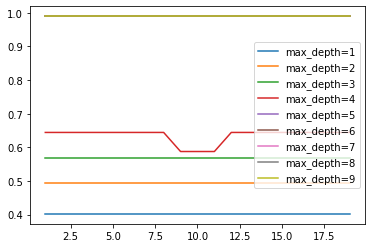

In [244]:
for d in range(1, 10, 1):
    df_subset = sc_df[sc_df.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.accuracy,
             label='max_depth=%d' % d)

plt.legend()

It's looked strange, but we can use model with max_depth from 5 and estimators from 1.
I think we will use model with max_depth=5 and n_estimators=3.

In [251]:
importances = model_rf.feature_importances_
importances

array([0.15506204, 0.04512403, 0.04400784, 0.18739164, 0.02627222,
       0.02516615, 0.51697608, 0.        , 0.        ])

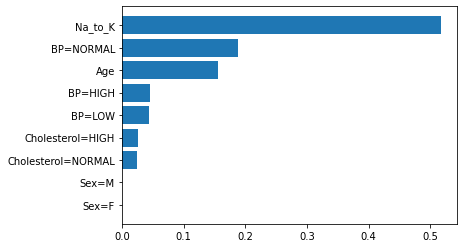

In [252]:
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(dv.get_feature_names())[indices])

Now let's train an XGBoost model

In [210]:
xgb_params = {  'eta': 0.4, 
                'max_depth': 7,
                'min_child_weight': 2,
                'num_class': 5,                
                'objective': 'multi:softmax',
                'nthread': 8,                
                'seed': 1,
                'verbosity': 1,
            }

In [211]:
features = dv.get_feature_names()
features

['Age',
 'BP=HIGH',
 'BP=LOW',
 'BP=NORMAL',
 'Cholesterol=HIGH',
 'Cholesterol=NORMAL',
 'Na_to_K',
 'Sex=F',
 'Sex=M']

In [212]:
dtrain = xgb.DMatrix(X_train, label=target_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=target_val, feature_names=features)

In [213]:
model = xgb.train(xgb_params, dtrain, num_boost_round=100)

In [214]:
y_pred = model.predict(dval).astype(int)
accuracy_score(target_val, y_pred).round(4)

0.9897

Not different in result with RF

## Select best model

We can use more simply model RF with max_depth=5 and n_estimators=3.

## Train best model on full train

In [255]:
X_full_train, X_test, dv_full = vectorize(feature_full_train, feature_test)

In [256]:
model_rf = RandomForestRegressor(n_estimators=3, max_depth=5, random_state=1, n_jobs=-1)
model_rf.fit(X_full_train, target_full_train)
y_pred_rf = model_rf.predict(X_test).astype(int)

accuracy_score(target_test, y_pred_rf)


1.0

It's best result

In [ ]:
model_rf.predict_proba(X_test)[:, 1][0].round(3)

## Save model

Model saving in train.py